This notebook demonstrates a predictive model for the completion time of a file, based on network parameters (throughput measure, # of files queued according to activity, and # of files completed over the previous hour) and per-file parameters (filesize, file activity type)

In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch
matplotlib.rc('font', **{'size': 15})


src = 'CERN-PROD'
dst = 'BNL-ATLAS'

#Create instance of ElasticSearch using the Atlas host server
es1 = Elasticsearch(hosts=[{'host':'atlas-kibana-2.mwt2.org', 'port':9200}],timeout=60)

In [2]:
query1 = '''{
    
  "size": 10000,
  "sort": [
    {
      "@timestamp": {
        "order": "random",
      }
    }
  ],
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "payload.src-rse:CERN* AND payload.dst-rse:BNL* AND event_type:transfer-done",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "@timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "fielddata_fields": [
    "@timestamp","duration"
  ]
}'''

In [3]:
import time

#Initialize convenient time intervals in milliseconds
currentMilliTime = int(round(time.time()*1000))
milliWeek = 7*24*60*60*1000
milliTwoWeek = 2*7*24*60*60*1000
milliThreeWeek = 3*7*24*60*60*1000
milliSixHour = 12*60*60*1000
milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
milliHalfDay = 12*60*60*1000

milliHour = 60*60*1000

For the purposes of this analysis, three weeks of network data will be taken. Because of the volume, per-file level data is acquired in chunks, and 100 random samples are taken from each chunk.

In [4]:
import ast

#Get three weeks of data
start = currentMilliTime - milliThreeWeek
end = currentMilliTime
hourSeg = 24*7*3
#Initialize lists
fileSize = []
activity = []
startedAt = []
submittedAt = []
transferredAt = []
duration = []
fileTimestamp = []

startPart = start
endPart = start


weekTimestamp = []
weekFileSize = []
weekActivity = []
weekStartedAt = []
weekSubmittedAt = []
weekTransferredAt = []

tic = time.time()
#Step through day, getting all data in range
for i in range(hourSeg):
    endPart += milliHour
    response = es1.search(index="rucio-events*", body=ast.literal_eval(query1%(startPart,endPart)), request_timeout=600)
    startPart = endPart + 1
    
    #Get important fields
    for r in response['hits']['hits']:
        fileTimestamp.append(r['fields']['@timestamp'])
        fileSize.append(r['_source']['payload']['file-size'])
        activity.append(r['_source']['payload']['activity'])
        startedAt.append(r['_source']['payload']['started_at'])
        submittedAt.append(r['_source']['payload']['submitted_at'])
        transferredAt.append(r['_source']['payload']['transferred_at'])
    
    
    #Get random indices in range of length of data vectors
    ind = np.random.choice(len(fileSize),size=100,replace=False)
    np.random.seed()
    
    #Append each random sample from the hour's data
    weekTimestamp += [ fileTimestamp[i] for i in ind]
    weekFileSize += [ fileSize[i] for i in ind]
    weekActivity += [ activity[i] for i in ind]
    weekStartedAt += [ startedAt[i] for i in ind]
    weekSubmittedAt += [ submittedAt[i] for i in ind]
    weekTransferredAt += [ transferredAt[i] for i in ind]

print("Done. Took %f seconds"%(time.time()-tic))   

Done. Took 271.865775 seconds


In [8]:
tic = time.time()

es2 = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)


src = 'CERN-PROD'
dst = 'BNL-ATLAS'


queryTemp = '''{
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "src:%s AND dst:%s",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "1h",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": %i,
          "max": %i
        }
      },
  "aggs": {
    "1": {
          "avg": {
            "field": 'queued-total'
          }
        },
        "2": {
          "avg": {
            "field": 'queued-User_Subscriptions'
          }
        },
        "3": {
          "avg": {
            "field": 'queued-T0_Export'
          }
        },
        "4": {
          "avg": {
            "field": 'queued-Data_Consolidation'
          }
        },
        "5": {
          "avg": {
            "field": 'queued-Functional_Test'
          }
        },
        "6": {
          "avg": {
            "field": 'queued-Express'
          }
        },
        "7": {
          "avg": {
            "field": 'queued-Production_Input'
          }
        },
        "8": {
          "avg": {
            "field": 'queued-Production_Output'
          }
        },
        "9": {
          "avg": {
            "field": 'queued-Staging'
          }
        },
        "10": {
          "avg": {
            "field": 'done-total-1h'
          }
        },
        "11": {
          "avg": {
            "field": 'done-User_Subscriptions-1h'
          }
        },
        "12": {
          "avg": {
            "field": 'done-T0_Export-1h'
          }
        },
        "13": {
          "avg": {
            "field": 'done-Data_Consolidation-1h'
          }
        },
        "14": {
          "avg": {
            "field": 'done-Functional_Test-1h'
          }
        },
        "15": {
          "avg": {
            "field": 'done-Express-1h'
          }
        },
        "16": {
          "avg": {
            "field": 'done-Production_Input-1h'
          }
        },
        "17": {
          "avg": {
            "field": 'done-Production_Output-1h'
          }
        },
        "18": {
          "avg": {
            "field": 'done-Staging-1h'
              }
            },
        
        
        "19": {
          "avg": {
            "field": 'packetloss'
              }
            },
        "20": {
          "avg": {
            "field": 'mbps-dashb-1h'
              }
            },
        "21": {
          "avg": {
            "field": 'mbps-dashb-1d'
              }
            },
        "22": {
          "avg": {
            "field": 'mbps-fts-1h'
              }
            },
        "23": {
          "avg": {
            "field": 'mbps-fts-1d'
              }
            },
        "24": {
          "avg": {
            "field": 'mbps-fax-1h'
              }
            },
        "25": {
          "avg": {
            "field": 'mbps-fax-1d'
              }
            }
      }
    }
  }
}'''

query = ast.literal_eval(queryTemp%(src,dst,start,end,start,end))
response = es2.search(index="atlas_ddm-metrics*", body=query, request_timeout=1000)

print("Done. Aggregation took %f seconds"%(time.time()-tic))

Done. Aggregation took 6.400906 seconds


Next, gather data about network health and activity.

In [338]:
timestamp = []

#Get current queued data according to activity
queuedTotal = []
queuedUserSubscriptions = []
queuedT0Export = []
queuedStaging = []
queuedDataConsolidation = []
queuedFunctionalTest = []
queuedExpress = []
queuedProductionInput = []
queuedProductionOutput = []
queuedStaging = []

#Get historical completion data according to activity
doneTotal = []
doneUserSubscriptions = []
doneT0Export = []
doneStaging = []
doneDataConsolidation = []
doneFunctionalTest = []
doneExpress = []
doneProductionInput = []
doneProductionOutput = []
doneStaging = []

#Get other parameters
packetloss = []
dashThroughput1h = []
dashThroughput1d = []
ftsThroughput1h = []
ftsThroughput1d = []
faxThroughput1h = []
faxThroughput1d = []

for r in response['aggregations']['2']['buckets']:
    queuedTotal.append(r['1']['value'])
    queuedUserSubscriptions.append(r['2']['value'])
    queuedT0Export.append(r['3']['value'])
    queuedDataConsolidation.append(r['4']['value'])
    queuedFunctionalTest.append(r['5']['value'])
    queuedExpress.append(r['6']['value'])
    queuedProductionInput.append(r['7']['value'])
    queuedProductionOutput.append(r['8']['value'])
    queuedStaging.append(r['9']['value'])

    doneTotal.append(r['10']['value'])
    doneUserSubscriptions.append(r['11']['value'])
    doneT0Export.append(r['12']['value'])
    doneDataConsolidation.append(r['13']['value'])
    doneFunctionalTest.append(r['14']['value'])
    doneExpress.append(r['15']['value'])
    doneProductionInput.append(r['16']['value'])
    doneProductionOutput.append(r['17']['value'])
    doneStaging.append(r['18']['value'])
    
    packetloss.append(r['19']['value'])
    dashThroughput1h.append(r['20']['value'])
    dashThroughput1d .append(r['21']['value'])
    ftsThroughput1h.append(r['22']['value'])
    ftsThroughput1d.append(r['23']['value'])
    faxThroughput1h.append(r['24']['value'])
    faxThroughput1d.append(r['25']['value'])                              
                      
    timestamp.append(r['key'])

In [339]:
#Convert lists to arrays, and None objects to NaNs
queuedTotal = np.array(queuedTotal,dtype = float)
queuedUserSubscriptions = np.array(queuedUserSubscriptions,dtype = float)
queuedT0Export = np.array(queuedT0Export,dtype = float)
queuedStaging = np.array(queuedStaging,dtype = float)
queuedDataConsolidation = np.array(queuedDataConsolidation,dtype = float)
queuedFunctionalTest = np.array(queuedFunctionalTest,dtype = float)
queuedExpress = np.array(queuedExpress,dtype = float)
queuedProductionInput = np.array(queuedProductionInput,dtype = float)
queuedProductionOutput = np.array(queuedProductionOutput,dtype = float)
queuedStaging = np.array(queuedStaging,dtype = float)


doneTotal = np.array(doneTotal,dtype = float)
doneUserSubscriptions = np.array(doneUserSubscriptions,dtype = float)
doneT0Export = np.array(doneT0Export,dtype = float)
doneStaging = np.array(doneStaging,dtype = float)
doneDataConsolidation = np.array(doneDataConsolidation,dtype = float)
doneFunctionalTest = np.array(doneFunctionalTest,dtype = float)
doneExpress = np.array(doneExpress,dtype = float)
doneProductionInput = np.array(doneProductionInput,dtype = float)
doneProductionOutput = np.array(doneProductionOutput,dtype = float)
doneStaging = np.array(doneStaging,dtype = float)

timestamp = np.array(timestamp, dtype=float)
packetloss = np.array(packetloss,dtype = float)
dashThroughput1h = np.array(dashThroughput1h,dtype=float)
dashThroughput1d = np.array(dashThroughput1d,dtype=float)
ftsThroughput1h = np.array(ftsThroughput1h,dtype=float)
ftsThroughput1d = np.array(ftsThroughput1d,dtype=float)
faxThroughput1h = np.array(faxThroughput1h,dtype=float)
faxThroughput1d = np.array(faxThroughput1d,dtype=float)


In [340]:
import datetime
from datetime import datetime

#Some useful functions for date conversion

def convertDateToDatetime(dates):
    '''
    Converts string dates to datetime objects
    '''
    datetimeDates = []
    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
        datetimeDates.append(epoch)
    return datetimeDates

def convertDateToMilliEpoch(dates):
    '''
    Converts string dates to milliEpoch values.
    '''
    epochDates = []
    zeroEpoch = datetime.utcfromtimestamp(0)    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
            
        epochDates.append((epoch - zeroEpoch).total_seconds() * 1000.0)
    return epochDates
        
        
    return datetimeDates

def getSecondsDifference(epochDatesStart,epochDatesFinal):
    diff = []
    for i in range(len(epochDatesStart)):
        diff.append((epochDatesFinal[i] - epochDatesStart[i]).total_seconds())
    
    return diff

In [341]:
#Convert string timestamps to usable quantities (each per-file, BTW)

timeInQueue = getSecondsDifference(convertDateToDatetime(weekSubmittedAt),
                                   convertDateToDatetime(weekStartedAt))
timeTotal = getSecondsDifference(convertDateToDatetime(weekSubmittedAt),
                                 convertDateToDatetime(weekTransferredAt))
timeInTransfer = getSecondsDifference(convertDateToDatetime(weekStartedAt),
                                      convertDateToDatetime(weekTransferredAt))

timeInTransfer = np.array(timeInTransfer)
timeTotal = np.array(timeTotal)
timeInQueue = np.array(timeInQueue)

In [342]:
#Get times that each file is submitted at

submittedTimes = np.array(convertDateToMilliEpoch(weekSubmittedAt))

#Get indices for sorting (use these indices to sort any ddm-metrics variables)
timeIndex = np.argsort(submittedTimes)

submittedTimes = submittedTimes[timeIndex]

#Sort according to monotonically increasing file-submitted timestamp
activity = np.array(weekActivity)[timeIndex]
filesize = np.array(weekFileSize)[timeIndex]
timeTotal = timeTotal[timeIndex]

In order to regress categorical data, I represented n choices for a categorical variable as an n-vector, where each index of the vector stood for a different category. The index for the appropriate category holds a value of 1, and the rest of the indices are zero.

In [343]:
#import pandas as pd
##Convert to panda dataframe, convert from categorical to numerical
#activity = {'activity':np.array(weekActivity)[timeIndex]}
#df = pd.DataFrame(activity)
#dummyActivity = np.array(pd.get_dummies(df['activity']))

uniqueActivities = np.unique(weekActivity)
num = len(uniqueActivities)

vec = np.zeros(num)

dummyActivity = []
for i in range(len(weekActivity)):
    vecNew = vec.copy()
    vecNew[np.where(uniqueActivities == weekActivity[i])] = 1
    dummyActivity.append(vecNew)
dummyActivity = np.array(dummyActivity)

In [344]:
#Get indices that relate the two timescales between metrics
binIndex = np.digitize(submittedTimes,timestamp)-1

#Make the bin sort

queuedTotal = queuedTotal[binIndex]

#Convert NaNs to zeros for all the queued datasets
queuedUserSubscriptions = np.nan_to_num(queuedUserSubscriptions)[binIndex]
queuedT0Export = np.nan_to_num(queuedT0Export)[binIndex]
queuedStaging = np.nan_to_num(queuedStaging)[binIndex]
queuedDataConsolidation = np.nan_to_num(queuedDataConsolidation)[binIndex]
queuedFunctionalTest = np.nan_to_num(queuedFunctionalTest)[binIndex]
queuedExpress = np.nan_to_num(queuedExpress)[binIndex]
queuedProductionInput = np.nan_to_num(queuedProductionInput)[binIndex]
queuedProductionOutput = np.nan_to_num(queuedProductionOutput)[binIndex]
queuedStaging = np.nan_to_num(queuedStaging)[binIndex]

doneTotal = doneTotal[binIndex]
#Convert NaNs to zeros for all the done datasets
doneUserSubscriptions = np.nan_to_num(doneUserSubscriptions)[binIndex]
doneT0Export = np.nan_to_num(doneT0Export)[binIndex]
doneStaging = np.nan_to_num(doneStaging)[binIndex]
doneDataConsolidation = np.nan_to_num(doneDataConsolidation)[binIndex]
doneFunctionalTest = np.nan_to_num(doneFunctionalTest)[binIndex]
doneExpress = np.nan_to_num(doneExpress)[binIndex]
doneProductionInput = np.nan_to_num(doneProductionInput)[binIndex]
doneProductionOutput = np.nan_to_num(doneProductionOutput)[binIndex]
doneStaging = np.nan_to_num(doneStaging)[binIndex]

loss = np.nan_to_num(packetloss)[binIndex]
times = timestamp[binIndex]
dash_through1h = dashThroughput1h[binIndex]
dash_through1d = dashThroughput1d[binIndex]
fts_through1d = ftsThroughput1d[binIndex]
fts_through1h = ftsThroughput1h[binIndex]
done_total1h = doneTotal[binIndex]


In [345]:
def convertSecsToCat(data):
    timeCategory = np.zeros(len(data),dtype=int)
    for i in range(len(data)):
        if data[i] < 600: #Less than 10 min
            timeCategory[i] = 0
        elif data[i] >= 600 and data[i] < 1200:#(10-20 min)
            timeCategory[i] = 1
        elif (data[i] >= 1200 and data[i] < 3600): #(between 20 min and 1 hour)
            timeCategory[i] = 2
        elif data[i] >=3600 and data[i] < 7200: #(between 1 and 2 hr)
            timeCategory[i] = 3
        elif data[i] >= 7200 and data[i] < 18000: #(2-5 hour)
            timeCategory[i] = 4
        elif data[i] >= 18000: #Greater than or equal to 5 hours
            timeCategory[i] = 5
    return timeCategory

In [346]:
#Form input by combining various variables
inputSample = np.squeeze(np.hstack((submittedTimes[:,None],queuedUserSubscriptions[:,None],
                                    queuedT0Export[:,None],queuedStaging[:,None],
                                    queuedDataConsolidation[:,None],queuedFunctionalTest[:,None],
                                    queuedExpress[:,None],queuedProductionInput[:,None],
                                    queuedProductionOutput[:,None],queuedStaging[:,None],
                                    doneUserSubscriptions[:,None],
                                    doneT0Export[:,None],doneStaging[:,None],
                                    doneDataConsolidation[:,None],doneFunctionalTest[:,None],
                                    doneExpress[:,None],doneProductionInput[:,None],
                                    doneProductionOutput[:,None],doneStaging[:,None],filesize[:,None],
                                    dash_through1h[:,None],dash_through1d[:,None],fts_through1h[:,None],fts_through1d[:,None],
                                    dummyActivity)))
outputSample = timeTotal

#Find rows of data that contain at least one missing value
missing = np.isnan(np.sum(inputSample,axis=1))

reducedInput = inputSample[~missing]
reducedOutput = outputSample[~missing]
activity = activity[~missing]

This took 1.185785 seconds


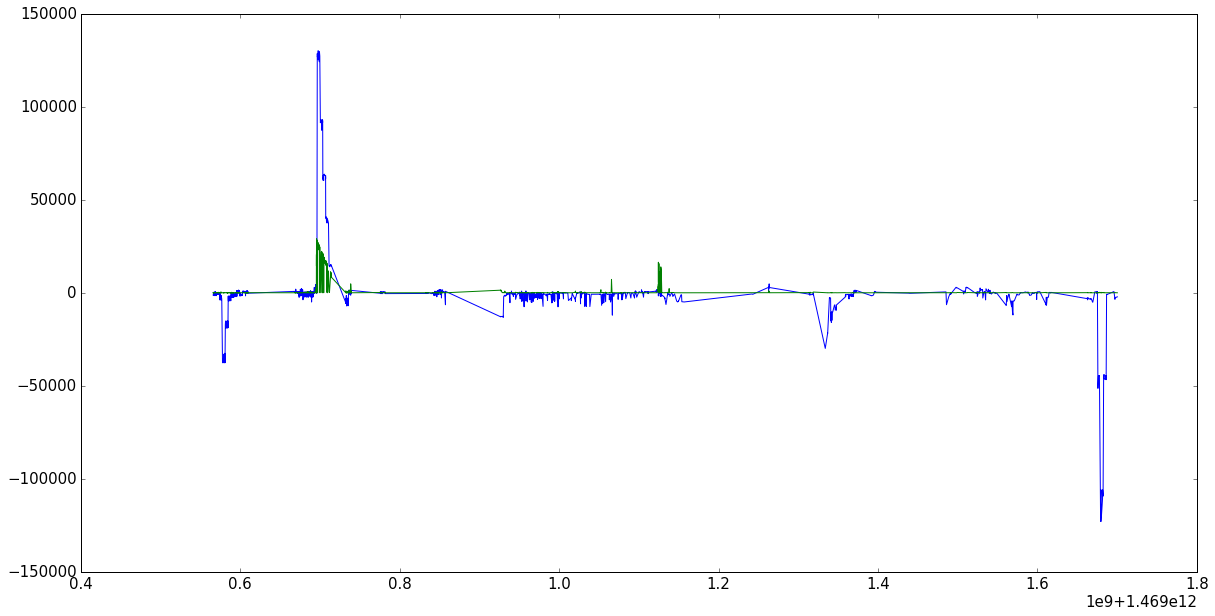

In [347]:
import pandas
from sklearn import cross_validation

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

tic = time.time()
sp = int(round(0.8*len(reducedOutput)))

X_train = reducedInput[:sp,:]
Y_train = reducedOutput[:sp]
X_test = reducedInput[sp:]
Y_test = reducedOutput[sp:]

poly = PolynomialFeatures(degree=2)
Xtrain_ = poly.fit_transform(X_train[:,1:])
Xtest_ = poly.fit_transform(X_test[:,1:])


clf = LinearRegression()
clf.fit(Xtrain_,Y_train)

Y_predict = clf.predict(Xtest_)
toc = time.time()

print("This took %f seconds"%(toc-tic))
plt.figure(figsize=(20,10))
plt.plot(X_test[:,0],Y_predict)
plt.plot(X_test[:,0],Y_test)


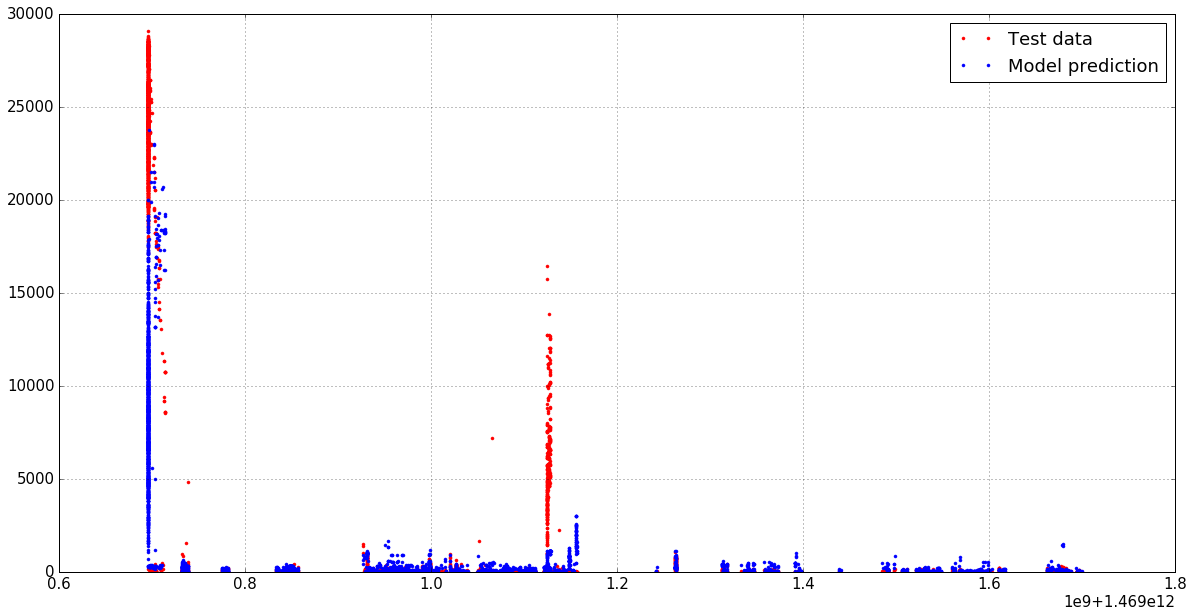

In [372]:
import pandas
from sklearn.linear_model import LinearRegression,BayesianRidge,Lars,Lasso
from sklearn.ensemble import (GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,
                              ExtraTreesRegressor)

sp = int(round(0.9*len(reducedOutput)))

X_train = reducedInput[:sp,:]
Y_train = reducedOutput[:sp]
X_test = reducedInput[sp:]
Y_test = reducedOutput[sp:]

model = BaggingRegressor()
Y_predict = model.fit(X_train[:,1:],Y_train).predict(X_test[:,1:])

plt.figure(figsize=(20,10))
plt.plot(X_test[:,0],Y_test,'r.',label='Test data')
plt.plot(X_test[:,0],Y_predict,'b.',label='Model prediction')
#plt.errorbar(X_test[:,0],Y_predict,yerr=np.abs(Y_predict-Y_test),linestyle='None',label='predicted')
plt.grid()
plt.legend()

/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


[ 0.22251868  0.89442719  1.80277564         nan  2.12952664  1.74756202]


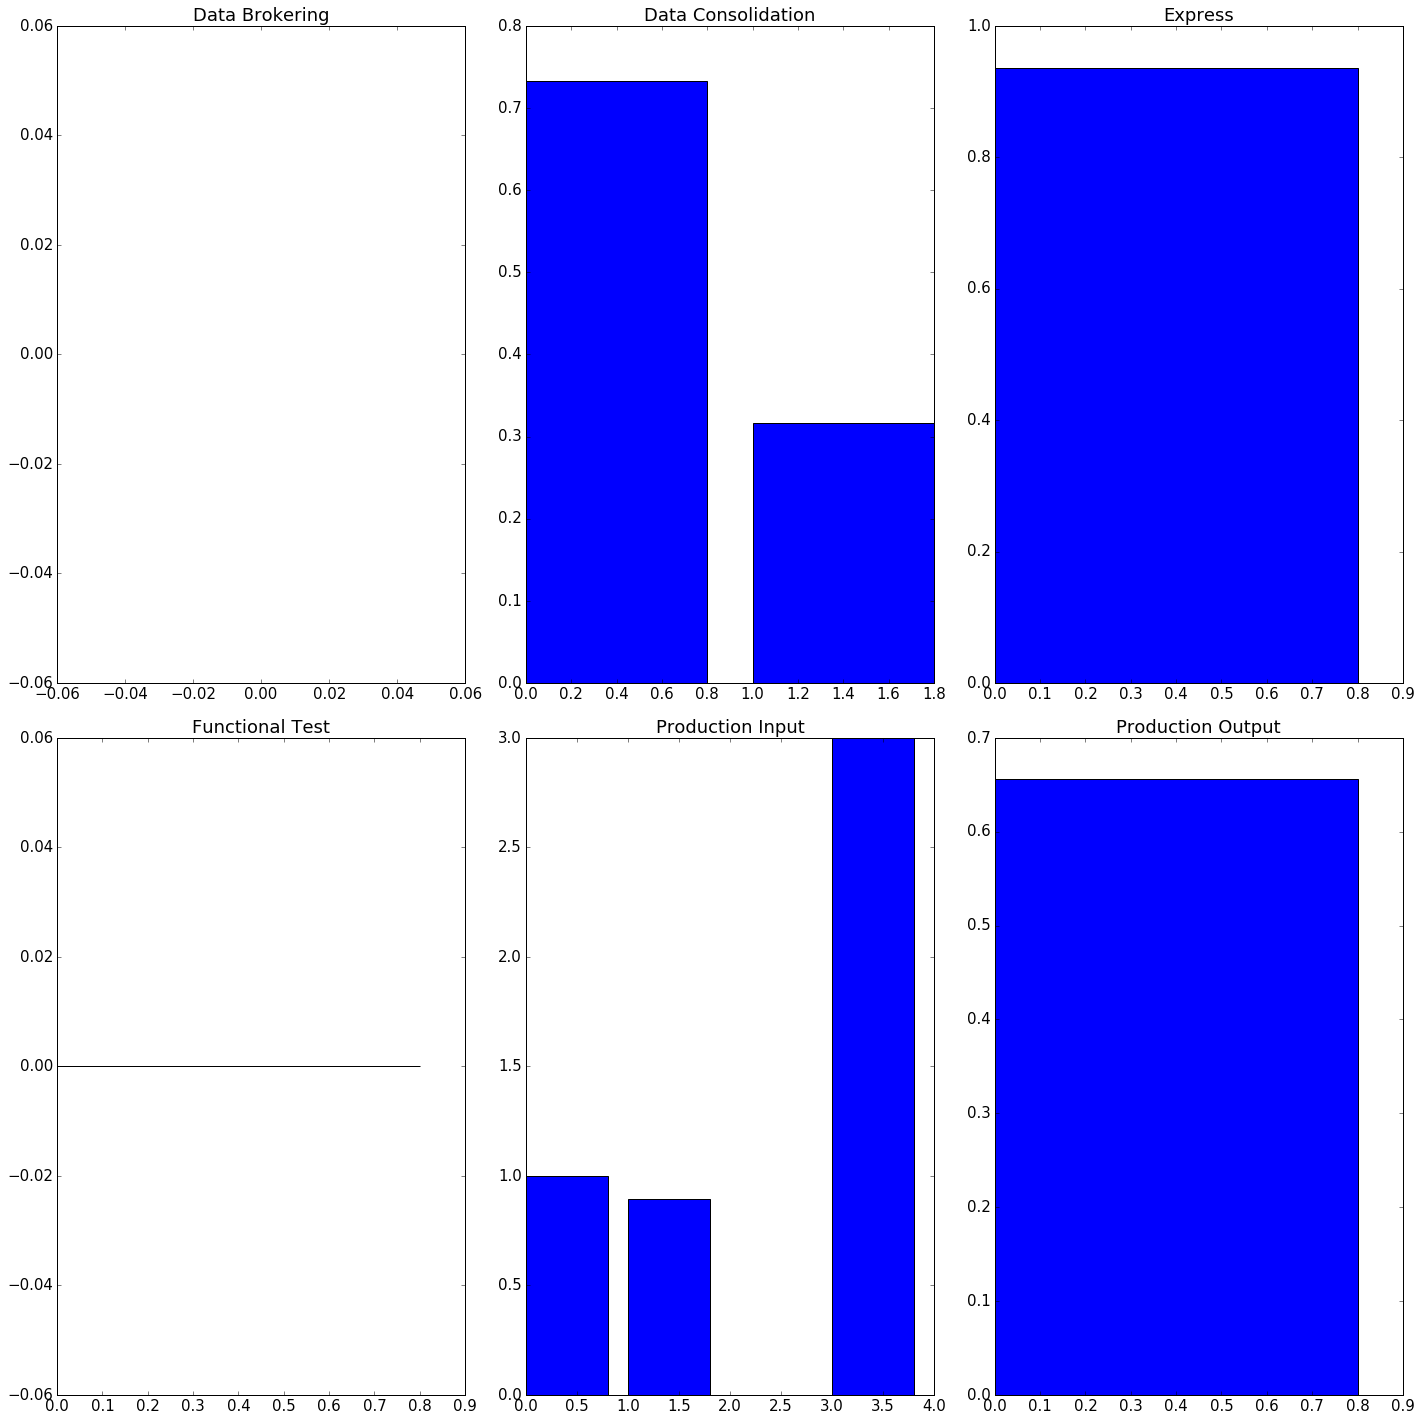

In [381]:
#Get performance statistics, broken down according to activity

rmseTotal = []
for i in range(len(uniqueActivities)):
    currentIndex = np.array(activity[sp:])==uniqueActivities[i]
    currentActivityTest = convertSecsToCat(Y_test[currentIndex])
    currentActivityPredict = convertSecsToCat(Y_predict[currentIndex])
    rmse = np.zeros(6)
    for j in range(6):
        index = currentActivityTest==j
        rmse[j] = np.sqrt(np.mean((currentActivityPredict[index] - currentActivityTest[index])**2))
    rmseTotal.append(rmse)

    
print(rmseTotal[7])
plt.figure(figsize=(20,20))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.bar(range(6),rmseTotal[i])
    plt.title(str(uniqueActivities[i]))
plt.tight_layout()

[            nan   2585.16255479   4097.68690943     75.9866
   2845.88781206   1794.16525829   6407.67644661  12426.32922078
    454.49097052]
['Data Brokering' 'Data Consolidation' 'Express' 'Functional Test'
 'Production Input' 'Production Output' 'Staging' 'T0 Export'
 'User Subscriptions']


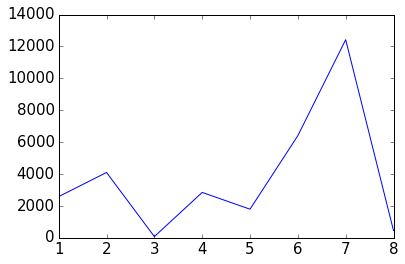

In [351]:
print(rmse)
print(uniqueActivities)
plt.plot(rmse)

In [169]:
from sklearn.metrics import hamming_loss

yPredictCategory = convertSecsToCat(Y_predict)
yTestCategory = convertSecsToCat(Y_test)
errors = np.zeros(6)
truePositives = np.zeros(6)
falsePositives = np.zeros(6)
totalNum = np.zeros(6)
for i in range(6):
    indices = (yTestCategory==i)
    truePositives[i] = np.sum((yPredictCategory[indices] ==i) | (yPredictCategory[indices] ==i+1) | (yPredictCategory[indices] ==i-1) )
    falsePositives[i] = np.sum((yPredictCategory[indices] !=i) and (yPredictCategory[indices] !=i+1) and (yPredictCategory[indices] !=i-1) )
    totalNum[i] = np.sum(indices)
plt.bar(range(6),errors)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Correctly classified time ratio is 0.831547619048


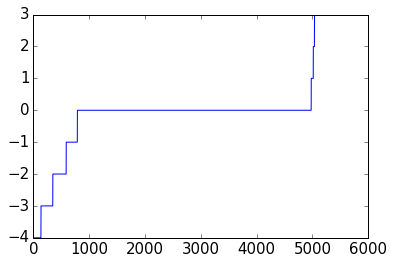

In [139]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier,
                              AdaBoostClassifier,ExtraTreesClassifier)

#Form input by combining various variables
inputSample = np.squeeze(np.hstack((submittedTimes[:,None],queuedUserSubscriptions[:,None],
                                    queuedT0Export[:,None],queuedStaging[:,None],
                                    queuedDataConsolidation[:,None],queuedFunctionalTest[:,None],
                                    queuedExpress[:,None],queuedProductionInput[:,None],
                                    queuedProductionOutput[:,None],queuedStaging[:,None],
                                    doneUserSubscriptions[:,None],
                                    doneT0Export[:,None],doneStaging[:,None],
                                    doneDataConsolidation[:,None],doneFunctionalTest[:,None],
                                    doneExpress[:,None],doneProductionInput[:,None],
                                    doneProductionOutput[:,None],doneStaging[:,None],filesize[:,None],
                                    dash_through1h[:,None],dummyActivity)))
outputSample = timeTotal

#Find rows of data that contain at least one missing value
missing = np.isnan(np.sum(inputSample,axis=1))

reducedInput = inputSample[~missing]
reducedOutput = outputSample[~missing]

sp = int(round(0.9*len(reducedOutput)))

X_train = reducedInput[:sp,:]
Y_train = convertSecsToCat(reducedOutput[:sp])
X_test = reducedInput[sp:]
Y_test = convertSecsToCat(reducedOutput[sp:])

model1 = BaggingClassifier()

results = model1.fit(X_train[:,1:],Y_train)

Y_predict = results.predict(X_test[:,1:])
Y_proba = results.predict_proba(X_test[:,1:])


diff = (Y_predict-Y_test)
indices4 = np.argsort(diff)

print('Correctly classified time ratio is ' + str(np.sum(diff==0)/len(diff)))
#Note the probabilities of the end objects are usually split between several categories
plt.plot(diff[indices4])

/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


<Container object of 6 artists>

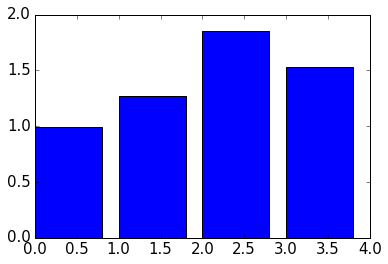

In [132]:
errors = np.zeros(6)
for i in range(6):
    indices = (Y_predict==i)
    errors[i] = (np.sqrt(np.mean((Y_predict[indices]-Y_test[indices])**2)))

plt.bar(range(6),errors)

In [131]:
errors

array([ 0.14712597,  1.02469508,  1.82639379,  2.9922017 ,  3.20543432,
               nan])